# Recommender System based on Collaborative Filtering

**Collaborative filtering** (CF) systems work by collecting user feedback in the form of ratings for items in a given domain and exploiting similarities in rating behavior among several users in determining how to recommend an item. The main advantage is that it requires no information about users or items and the more users interact with items the more new recommendations become accurate. However, as it only consider past interactions to make recommendations, collaborative filtering suffer from the **“cold start problem”**, which means that it is impossible to recommend anything to new users or to recommend a new item to any users and many users or items have too few interactions to be efficiently handled.

## Download Datasets

In the project, I am planning to use [MovieLens]{https://grouplens.org/datasets/movielens/} as the dataset

In [ ]:
import os
import re
import pickle
import hashlib
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from os.path import isfile, isdir
from urllib.request import urlretrieve
from tensorflow.python.ops import math_ops
from sklearn.model_selection import train_test_split

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
def _unzip(save_path, _, database_name, data_path):
    """Unzip wrapper with the same interface as _ungzip
    Args:
        save_path: The path of the gzip files
        database_name: Name of database
        data_path: Path to extract to
        _: HACK - Used to have to same interface as _ungzip
    """
    print(f'Extracting { database_name }...')
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)

def download_extract(database_name, data_path):
    """Download and extract database
    Args:
        database_name: Database name
        data_path: Path to extract to
    """
    DATASET_NAME = 'ml-1m'
    if database_name == DATASET_NAME:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, DATASET_NAME)
        save_path = os.path.join(data_path, f'{ DATASET_NAME }.zip')
        extract_fn = _unzip
        
    if os.path.exists(extract_path):
        print(f'Found { database_name } Data')
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc=f'Downloading { database_name }') as pbar:
            urlretrieve(url, save_path, pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        f'{ save_path } file is corrupted.  Remove the file and try again.'

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    print('Done downloading and extracing')
    
class DLProgress(tqdm):
    """Handle Progress Bar while Downloading"""
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        Args:
            block_num: A count of blocks transferred so far
            block_size: Block size in bytes
            total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [ ]:
data_dir = './'
download_extract('ml-1m', data_dir)

Extracting ml-1m...
Done downloading and extracing


## View the Dataset

The movie dataset includes three parts: users'data - **users.dat**, movies'data - **movies.dat**, ratings'data - **ratings.dat**

### Uses' Data

In [ ]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### Movies' Data

In [ ]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title,encoding='latin-1', engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### Ratings' Data

In [ ]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title,encoding='latin-1', engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Preprocessing

1. Gender: change **F** to **0** and change **M** to **1**
2. Age: transform to continous numbers from 0 to 7
3. Genres: transform to digits
4. Title: same as **Genres**

Notes: The length of **Genres** and **Title** should be same.

In [ ]:
def load_data():
    """Load dataset from file and then preprocessing it"""
    # Load users' data
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, encoding='latin-1',engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_origin = users.values
    # Preprocess users' gender and age attributes
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)
    age_map = {val:idx for idx, val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)
    
    # Load movies' data
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title,encoding='latin-1', engine = 'python')
    movies_origin = movies.values
    # Remove year from title
    pattern = re.compile(r'^(.*)\((\d+)\)$')
    title_map = {title:pattern.match(title).group(1) for title in set(movies['Title'])}
    movies['Title'] = movies['Title'].map(title_map)
    # Change movies' genre to dict with numbers
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)
    genres_set.add('<PAD>')
    genres2int = {val:idx for idx, val in enumerate(genres_set)}
    genres_map = {val:[genres2int[row] for row in val.split('|')] for val in set(movies['Genres'])}
    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt, genres2int['<PAD>'])
    movies['Genres'] = movies['Genres'].map(genres_map)

    # Change movies' title to dict with numbers
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    title_set.add('<PAD>')
    title2int = {val:idx for idx, val in enumerate(title_set)}
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for val in set(movies['Title'])}
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt, title2int['<PAD>'])
    movies['Title'] = movies['Title'].map(title_map)

    # Load ratings' data
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, encoding='latin-1',names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    # Merge
    data = pd.merge(pd.merge(ratings, users), movies)
    
    # Split data into two parts
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin

In [ ]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin = load_data()
pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin), open('preprocess_movies.pkl', 'wb'))

In [ ]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [ ]:
movies.head()

,MovieID,Title,Genres
0,1,"[538, 4030, 4500, 4500, 4500, 4500, 4500, 4500...","[10, 6, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12..."
1,2,"[992, 4500, 4500, 4500, 4500, 4500, 4500, 4500...","[14, 6, 1, 12, 12, 12, 12, 12, 12, 12, 12, 12,..."
2,3,"[3179, 294, 4234, 4500, 4500, 4500, 4500, 4500...","[13, 2, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12..."
3,4,"[4259, 5115, 2380, 4500, 4500, 4500, 4500, 450...","[13, 15, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
4,5,"[1987, 2306, 2707, 3855, 882, 64, 4500, 4500, ...","[13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."


## Design Model

### Helpers

In [ ]:
def save_params(params):
    """Save parameters to file"""
    pickle.dump(params, open('params.pkl', 'wb'))


def load_params():
    """Load parameters from file"""
    return pickle.load(open('params.pkl', 'rb'))

In [ ]:
# Dimension of matrix
embed_dim = 32
# Number of users' ids
uid_max = max(features.take(0,1)) + 1 # 6040
# Number of genders
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
# Number of ages
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
# Number of jobs
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

# Number of movies
movie_id_max = max(features.take(1,1)) + 1 # 3952
# Number of genres
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
# Number of words of movies' names
movie_title_max = len(title_set) # 5216

combiner = "sum"

# Length of movies' name
sentences_size = title_count # = 15

window_sizes = {2, 3, 4, 5}
filter_num = 8
movieid2idx = {val[0]:idx for idx, val in enumerate(movies.values)}

### Hyperparameters

In [ ]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

### Model's Input

In [ ]:
def get_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')  
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')  
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age') 
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')

    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id') 
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories') 
    movie_titles = tf.keras.layers.Input(shape=(15,), dtype='int32', name='movie_titles') 
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles

### Build Neural Network

#### Define User's Embedding Matrix

In [ ]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1, name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(user_age)
    job_embed_layer = tf.keras.layers.Embedding(job_max, embed_dim // 2, input_length=1, name='job_embed_layer')(user_job)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

#### Define User's Feature

It is based on two fully connected layers, **1x128** and **1x200**

In [ ]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    # First FCL
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embed_dim, name="job_fc_layer", activation='relu')(job_embed_layer)

    # Second FCL
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
    user_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(user_combine_layer)  #(?, 1, 200)

    user_combine_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_combine_layer)
    return user_combine_layer, user_combine_layer_flat

#### Define Movie's ID Embedding Matrix

In [ ]:
def get_movie_id_embed_layer(movie_id):
    movie_id_embed_layer = tf.keras.layers.Embedding(movie_id_max, embed_dim, input_length=1, name='movie_id_embed_layer')(movie_id)
    return movie_id_embed_layer

#### Define Movie's Genre Embedding Matrix

In [ ]:
def get_movie_categories_layers(movie_categories):
    movie_categories_embed_layer = tf.keras.layers.Embedding(movie_categories_max, embed_dim, input_length=18, name='movie_categories_embed_layer')(movie_categories)
    movie_categories_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(movie_categories_embed_layer)
    return movie_categories_embed_layer

#### Define CNN of Movie's Title

In [ ]:
def get_movie_cnn_layer(movie_titles):
    movie_title_embed_layer = tf.keras.layers.Embedding(movie_title_max, embed_dim, input_length=15, name='movie_title_embed_layer')(movie_titles)
    sp = movie_title_embed_layer.shape
    movie_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(movie_title_embed_layer)
    pool_layer_lst = []
    for window_size in window_sizes:
        conv_layer = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(movie_title_embed_layer_expand)
        maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1), strides=1)(conv_layer)
        pool_layer_lst.append(maxpool_layer)
    pool_layer = tf.keras.layers.concatenate(pool_layer_lst, 3, name ="pool_layer")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat")(pool_layer)

    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(pool_layer_flat)
    return pool_layer_flat, dropout_layer

#### Define Movie's Feature

It is based on two fully connected layers, **1x64** and **1x200**

In [ ]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    # First FCL 64
    movie_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_id_fc_layer", activation='relu')(movie_id_embed_layer)
    movie_categories_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_categories_fc_layer", activation='relu')(movie_categories_embed_layer)

    # Second FCL 200
    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  
    movie_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(movie_combine_layer)

    movie_combine_layer_flat = tf.keras.layers.Reshape([200], name="movie_combine_layer_flat")(movie_combine_layer)
    return movie_combine_layer, movie_combine_layer_flat

In [ ]:
tf.keras.layers

<module 'keras.api._v2.keras.layers' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/layers/__init__.py'>

### Build Computing Graph

In [ ]:
import time
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2

In [ ]:
MODEL_DIR = "./models"

In [ ]:
class mrs_network():
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_rmse = 99999
        self.losses = {'train': [], 'test': []}
        
        # User's input
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles = get_inputs()
        
        # User's embedding layers
        uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, 
                                                                                                   user_gender,
                                                                                                   user_age,
                                                                                                   user_job)
        # User's feature
        user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, 
                                                                             gender_embed_layer, 
                                                                             age_embed_layer, 
                                                                             job_embed_layer)
        
        # Movie's id embedding layer
        movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
        # Movie's genre embedding layer
        movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
        # Movie's name layer
        pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
        # Movie's feature
        movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer,
                                                                                movie_categories_embed_layer,
                                                                                dropout_layer)
        # Combine user's feature and movie's feature to get rating prediction
        inference = tf.keras.layers.Lambda(lambda layer: 
            tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, movie_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)
        
        self.model = tf.keras.Model(
            inputs=[uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles],
            outputs=[inference])

        self.model.summary()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        # MSE Loss
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.RootMeanSquaredError()
        
        if tf.io.gfile.exists(MODEL_DIR):
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.rmse(labels, logits)
        
    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6]], training=True)
            loss = self.ComputeLoss(y, logits)
            self.ComputeMetrics(y, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits
    
    def training(self, features, targets_values, epochs=5, log_freq=50):
        for epoch_i in range(epochs):
            # separate the dataset into training and testing
            train_X, test_X, train_y, test_y = train_test_split(features,
                                                                targets_values,
                                                                test_size=0.2,
                                                                random_state=0)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)
            train_start = time.time()
            
            if True:
                start = time.time()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(6, 1)[i]

                    titles = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(5, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} rmse: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        start = time.time()

            train_end = time.time()
            print('\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, 
                                                                           self.optimizer.iterations.numpy(),
                                                                           train_end - train_start))
            self.testing((test_X, test_y), self.optimizer.iterations)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)
    
    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(6, 1)[i]

            titles = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(5, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            # Save testing loss
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)

        print('Model test set loss: {:0.6f} rmse: {:0.6f}'.format(avg_loss.result(), 
                                                                 self.ComputeMetrics.result()))
        if(self.ComputeMetrics.result() < self.best_rmse):
          self.best_rmse = self.ComputeMetrics.result()
          print(f'best rmse = { self.best_rmse }')
          self.checkpoint.save(self.checkpoint_prefix)

    
    def forward(self, xs):
        predictions = self.model(xs)
        return predictions

### Get Batch

In [ ]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

### Train Network

Input the user's feature and movie's feature, output the training result through the fully connected layer

In [ ]:
mrs_net = mrs_network()
mrs_net.training(features, targets_values, epochs=5)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie_titles (InputLayer)      [(None, 15)]         0           []                               
                                                                                                  
 movie_title_embed_layer (Embed  (None, 15, 32)      166944      ['movie_titles[0][0]']           
 ding)                                                                                            
                                                                                                  
 reshape (Reshape)              (None, 15, 32, 1)    0           ['movie_title_embed_layer[0][0]']
                                                                                                  
 conv2d (Conv2D)                (None, 14, 1, 8)     520         ['reshape[0][0]']            

### Visualize Training Loss

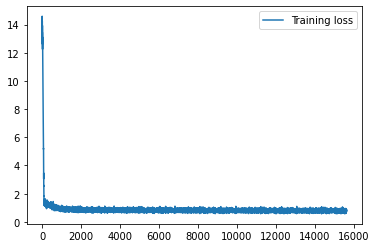

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mrs_net.losses['train'], label='Training loss')
plt.legend()
plt.show()

### Visualize Testing Loss

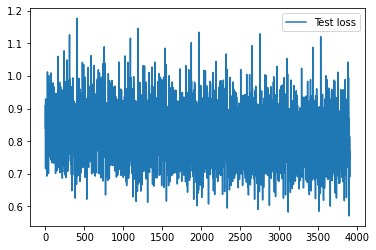

In [ ]:
plt.plot(mrs_net.losses['test'], label='Test loss')
plt.legend()
plt.show()

### Rate Given User and Movie

In [ ]:
def rating_movie(mrs_net, user_id_val, movie_id_val):
    categories = np.zeros([1, 18])
    categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
    titles = np.zeros([1, sentences_size])
    titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
    inference_val = mrs_net.model([np.reshape(users.values[user_id_val-1][0], [1, 1]),
              np.reshape(users.values[user_id_val-1][1], [1, 1]),
              np.reshape(users.values[user_id_val-1][2], [1, 1]),
              np.reshape(users.values[user_id_val-1][3], [1, 1]),
              np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              categories,  
              titles])

    return (inference_val.numpy())

### Save User's Feature

In [ ]:
user_layer_model = keras.models.Model(inputs=[mrs_net.model.input[0], mrs_net.model.input[1], mrs_net.model.input[2], mrs_net.model.input[3]], 
                                 outputs=mrs_net.model.get_layer("user_combine_layer_flat").output)
users_matrics = []

for item in users.values:
    user_combine_layer_flat_val = user_layer_model([np.reshape(item.take(0), [1, 1]), 
                                                    np.reshape(item.take(1), [1, 1]), 
                                                    np.reshape(item.take(2), [1, 1]), 
                                                    np.reshape(item.take(3), [1, 1])])  
    users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.pkl', 'wb'))

In [ ]:
users_matrics = pickle.load(open('users_matrics.pkl', mode='rb'))
print(users_matrics)

[[-0.00321702 -0.09089328 -0.02635128 ... -0.06640862 -0.00116399
  -0.05063942]
 [-0.01665238 -0.01922891 -0.07042468 ... -0.02603988  0.04352098
  -0.04237579]
 [ 0.00117174 -0.01110188 -0.05033495 ... -0.02664727  0.04094043
  -0.03344682]
 ...
 [-0.01405391 -0.11476086 -0.07478969 ... -0.04480696 -0.02455059
  -0.06973559]
 [-0.04776129 -0.09942249 -0.05475966 ... -0.05797588 -0.0311058
  -0.08214524]
 [-0.05255647 -0.00931738 -0.05161802 ...  0.00208724 -0.06019311
  -0.01966193]]


### Save Movie's Feature

In [ ]:
movie_layer_model = keras.models.Model(inputs=[mrs_net.model.input[4], mrs_net.model.input[5], mrs_net.model.input[6]], 
                                 outputs=mrs_net.model.get_layer("movie_combine_layer_flat").output)
movie_matrics = []

for item in movies.values:
    categories = np.zeros([1, 18])
    categories[0] = item.take(2)

    titles = np.zeros([1, sentences_size])
    titles[0] = item.take(1)

    movie_combine_layer_flat_val = movie_layer_model([np.reshape(item.take(0), [1, 1]), categories, titles])  
    movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.pkl', 'wb'))

In [ ]:
movie_matrics = pickle.load(open('movie_matrics.pkl', mode='rb'))
print(movie_matrics)

[[-0.49142566 -0.40400138 -0.5319641  ... -0.27717316 -0.40968475
  -0.51434034]
 [-0.28648397 -0.3716132  -0.43718812 ... -0.25332248 -0.06870798
  -0.47232157]
 [-0.20940673 -0.38718307 -0.346356   ... -0.3383206  -0.00328024
  -0.51792294]
 ...
 [-0.40831864 -0.351856   -0.42770928 ... -0.36755925 -0.25672665
  -0.5426193 ]
 [-0.45576802 -0.31501547 -0.45892015 ... -0.35322016 -0.3630539
  -0.5464134 ]
 [-0.44551364 -0.3471051  -0.4095839  ... -0.33541015 -0.2747999
  -0.5616216 ]]


### Recommend Movie

#### Recommend movies with same genre

The ides is to 

1. Compute the **cosine similarity** of the given movie and the whole movies' feature matrix
2. Return top k max similarity values
3. Select randomly to make sure each recommendation id distinct

In [ ]:
# print(movieid2idx)
# print(tf.reshape(movie_matrics[movieid2idx[2]], [1, 200]))
norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keepdims=True))
normalized_movie_matrics = movie_matrics / norm_movie_matrics
print(tf.transpose(normalized_movie_matrics))

tf.Tensor(
[[-0.0741367  -0.05376326 -0.0402433  ... -0.06964973 -0.07217798
  -0.0726875 ]
 [-0.06094783 -0.0697391  -0.07440794 ... -0.06001851 -0.04988762
  -0.05663171]
 [-0.08025235 -0.08204527 -0.06656189 ... -0.07295733 -0.07267717
  -0.0668254 ]
 ...
 [-0.04181447 -0.04753998 -0.06501766 ... -0.06269713 -0.05593793
  -0.05472364]
 [-0.06180523 -0.01289414 -0.00063039 ... -0.04379164 -0.05749525
  -0.04483481]
 [-0.07759362 -0.08863862 -0.09953322 ... -0.09255833 -0.08653309
  -0.09163103]], shape=(200, 3883), dtype=float32)


In [ ]:
def recommend_same_genre_movie(movie_id_val, top_k = 20):
   
    norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keepdims=True))
    normalized_movie_matrics = movie_matrics / norm_movie_matrics

    # Recommend movies with same genre
    probs_embeddings = tf.reshape(movie_matrics[movieid2idx[movie_id_val]], [1, 200])
    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
    sim = (probs_similarity.numpy())

    print(f"The movie you're watching is：{ movies_origin[movieid2idx[movie_id_val]] }")
    print("Here are recommendations for you：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_origin[val])
        
    return results

In [ ]:
recommend_same_genre_movie(1, 20)

The movie you're watching is：[1 'Toy Story (1995)' "Animation|Children's|Comedy"]
Here are recommendations for you：
3045
[3114 'Toy Story 2 (1999)' "Animation|Children's|Comedy"]
935
[947 'My Man Godfrey (1936)' 'Comedy']
886
[898 'Philadelphia Story, The (1940)' 'Comedy|Romance']
2327
[2396 'Shakespeare in Love (1998)' 'Comedy|Romance']
2719
[2788 'And Now for Something Completely Different (1971)' 'Comedy']


{886, 935, 2327, 2719, 3045}

#### Recommend movies you may like

1. Compute the **cosine similarity** of the given user and the whole movies' feature matrix
2. Return top k max similarity values
3. Select randomly to make sure each recommendation id distinct

In [ ]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):
    # Recommend your favorite movies
    probs_embeddings = tf.reshape(users_matrics[user_id_val-1], [1, 200])
    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    
    print("Here are recommendations for you：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_origin[val])

    return results

In [ ]:
recommend_your_favorite_movie(2434, 10)

Here are recommendations for you：
2434
[2503 'Apple, The (Sib) (1998)' 'Drama']
49
[50 'Usual Suspects, The (1995)' 'Crime|Thriller']
52
[53 'Lamerica (1994)' 'Drama']
2836
[2905 'Sanjuro (1962)' 'Action|Adventure']
1950
[2019
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'Action|Drama']


{49, 52, 1950, 2434, 2836}

#### Recommend other favorite movies according to the given movie

1. Select top k users who like the given movie in order to obtain their feature matrix
2. Calculate rating of all movies given by these users
3. Recommend movies with highest ratings
4. Select movies with same ratings randomly

In [ ]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    probs_movie_embeddings = tf.reshape(movie_matrics[movieid2idx[movie_id_val]], [1, 200])
    probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
    favorite_user_id = np.argsort(probs_user_favorite_similarity.numpy())[0][-top_k:]
    
    print(f"The movie you watching is：{ movies_origin[movieid2idx[movie_id_val]] }")
    print(f"People who like the movie are：{ users_origin[favorite_user_id - 1] }")
    
    probs_users_embeddings = tf.reshape(users_matrics[favorite_user_id-1], [-1, 200])
    probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    p = np.argmax(sim, 1)
    print("Other movies may like：")

    if len(set(p)) < 5:
        results = set(p)
    else:
        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
    for val in (results):
        print(val)
        print(movies_origin[val])
        
    return results

In [ ]:
users_matrics = pickle.load(open('users_matrics.pkl', mode='rb'))
print(users_matrics)
movie_matrics = pickle.load(open('movie_matrics.pkl', mode='rb'))
print(movie_matrics)

[[-0.00321702 -0.09089328 -0.02635128 ... -0.06640862 -0.00116399
  -0.05063942]
 [-0.01665238 -0.01922891 -0.07042468 ... -0.02603988  0.04352098
  -0.04237579]
 [ 0.00117174 -0.01110188 -0.05033495 ... -0.02664727  0.04094043
  -0.03344682]
 ...
 [-0.01405391 -0.11476086 -0.07478969 ... -0.04480696 -0.02455059
  -0.06973559]
 [-0.04776129 -0.09942249 -0.05475966 ... -0.05797588 -0.0311058
  -0.08214524]
 [-0.05255647 -0.00931738 -0.05161802 ...  0.00208724 -0.06019311
  -0.01966193]]
[[-0.49142566 -0.40400138 -0.5319641  ... -0.27717316 -0.40968475
  -0.51434034]
 [-0.28648397 -0.3716132  -0.43718812 ... -0.25332248 -0.06870798
  -0.47232157]
 [-0.20940673 -0.38718307 -0.346356   ... -0.3383206  -0.00328024
  -0.51792294]
 ...
 [-0.40831864 -0.351856   -0.42770928 ... -0.36755925 -0.25672665
  -0.5426193 ]
 [-0.45576802 -0.31501547 -0.45892015 ... -0.35322016 -0.3630539
  -0.5464134 ]
 [-0.44551364 -0.3471051  -0.4095839  ... -0.33541015 -0.2747999
  -0.5616216 ]]


In [ ]:
recommend_other_favorite_movie(1401, 20)

The movie you watching is：[1401 'Ghosts of Mississippi (1996)' 'Drama']
People who like the movie are：[[287 'M' 50 13]
 [1701 'F' 25 4]
 [566 'M' 25 17]
 [1669 'F' 25 17]
 [3323 'M' 35 14]
 [4754 'F' 18 0]
 [2693 'M' 56 13]
 [4200 'M' 45 7]
 [1855 'M' 18 4]
 [4085 'F' 25 6]
 [445 'M' 45 12]
 [4800 'M' 18 4]
 [100 'M' 35 17]
 [2338 'M' 45 17]
 [371 'M' 18 4]
 [5861 'F' 50 1]
 [282 'M' 25 17]
 [3901 'M' 18 14]
 [446 'F' 50 0]
 [2154 'M' 25 12]]
Other movies may like：
2693
[2762 'Sixth Sense, The (1999)' 'Thriller']
847
[858 'Godfather, The (1972)' 'Action|Crime|Drama']
2128
[2197 'Firelight (1997)' 'Drama']
2836
[2905 'Sanjuro (1962)' 'Action|Adventure']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']


{315, 847, 2128, 2693, 2836}